<a href="https://colab.research.google.com/github/algo74/MLCourse/blob/master/HW3/HW3_Problem1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using VGG19 with data augmentation

This is based on `pretrained_convnet_feature_extraction_data_augmentation.ipynb`



## Preparing saving to files

I saved files to my Google Drive so that I can reload them in other notebooks even in another session

This code needs to be changed if not saving to Google Drive

In [0]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
file_prefix = '/gdrive/My Drive/HW3/'

Mounted at /gdrive


In [0]:
# test saving files
with open(file_prefix + 'foo.txt', 'w') as f:
  f.write('Hello Google Drive!')
!cat "{file_prefix}foo.txt"

Hello Google Drive!

## Download the data

Download the example data, a zip. of 2,000 JPG pictures of cats and dogs and extract it locally in ```/tmp```.



In [0]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2019-04-14 16:52:19--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.15.128, 2a00:1450:400c:c0b::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.15.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  73.9MB/s    in 0.9s    

2019-04-14 16:52:21 (73.9 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

Note that the data provided by Google does not have a test set.

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

## Build network with VGG19 convolution base and custom densely connected layers

### Load the convolutional base

In [0]:
from keras.applications import VGG19

conv_base = VGG19(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3))

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


In [0]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

### Freeze the convolutional base

In [0]:
conv_base.trainable = False

### Concatenate the convolutional base and densely connected layers

In [0]:
from keras import layers
from keras import models
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
# This name is used for names of the files where the progress is saved
model_name = 'Problem1_take6'


In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 22,122,049
Trainable params: 2,097,665
Non-trainable params: 20,024,384
_________________________________________________________________


## Train the model end to end with frozen convolutional base

In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg19 import preprocess_input
from keras import optimizers
from keras import callbacks

# data augmentation

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    # rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=[0.8, 1.4],
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

# compile model

model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(lr=2e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    callbacks = [callbacks.ReduceLROnPlateau(monitor='loss', patience=10, factor=0.3, verbose=1, min_lr=1e-7)],
    validation_data=validation_generator,
    validation_steps=50
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
100/100 [==============================] - 30s 305ms/step - loss: 3.0572 - acc: 0.6905 - val_loss: 1.2511 - val_acc: 0.8640
Epoch 2/30
100/100 [==============================] - 27s 273ms/step - loss: 1.6535 - acc: 0.8150 - val_loss: 0.6797 - val_acc: 0.9230
Epoch 3/30
100/100 [==============================] - 27s 273ms/step - loss: 1.2025 - acc: 0.8550 - val_loss: 0.5480 - val_acc: 0.9350
Epoch 4/30
100/100 [==============================] - 27s 271ms/step - loss: 1.0200 - acc: 0.8725 - val_loss: 0.5230 - val_acc: 0.9420
Epoch 5/30
100/100 [==============================] - 27s 271ms/step - loss: 0.9172 - acc: 0.8925 - val_loss: 0.4456 - val_acc: 0.9530
Epoch 6/30
100/100 [==============================] - 28s 279ms/step - loss: 0.8581 - acc: 0.8895 - val_loss: 0.4145 - val_acc: 0.9560
Epoch 7/30
100/100 [==============================] - 28s 

In [0]:
model.save(file_prefix + model_name + '_step1.h5' )

## Display curves of loss and accuracy during training

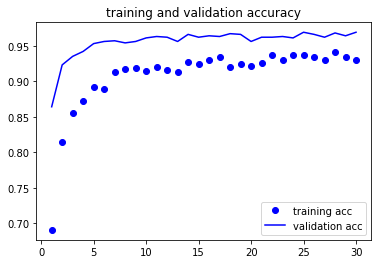

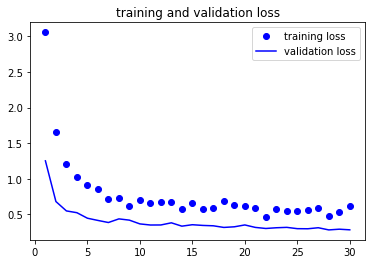

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

## Train with smaller learning rate

In [0]:
model.compile(
    loss='binary_crossentropy', 
    #
    # decrease learning rate
    #
    optimizer=optimizers.RMSprop(lr=1e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    callbacks = [callbacks.ReduceLROnPlateau(monitor='loss', patience=15, factor=0.3, verbose=1, min_lr=1e-7)],
    validation_data=validation_generator,
    validation_steps=50
)

Epoch 1/100
100/100 [==============================] - 30s 304ms/step - loss: 0.4956 - acc: 0.9425 - val_loss: 0.2992 - val_acc: 0.9670
Epoch 2/100
100/100 [==============================] - 28s 277ms/step - loss: 0.4888 - acc: 0.9395 - val_loss: 0.2607 - val_acc: 0.9680
Epoch 3/100
100/100 [==============================] - 28s 279ms/step - loss: 0.4864 - acc: 0.9355 - val_loss: 0.2688 - val_acc: 0.9660
Epoch 4/100
100/100 [==============================] - 28s 280ms/step - loss: 0.4777 - acc: 0.9395 - val_loss: 0.2743 - val_acc: 0.9630
Epoch 5/100
100/100 [==============================] - 28s 281ms/step - loss: 0.4763 - acc: 0.9395 - val_loss: 0.2520 - val_acc: 0.9630
Epoch 6/100
100/100 [==============================] - 28s 278ms/step - loss: 0.4263 - acc: 0.9420 - val_loss: 0.2896 - val_acc: 0.9570
Epoch 7/100
100/100 [==============================] - 28s 279ms/step - loss: 0.4979 - acc: 0.9445 - val_loss: 0.2929 - val_acc: 0.9660
Epoch 8/100
100/100 [===========================

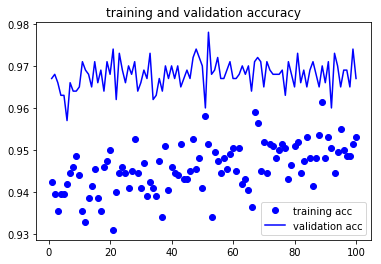

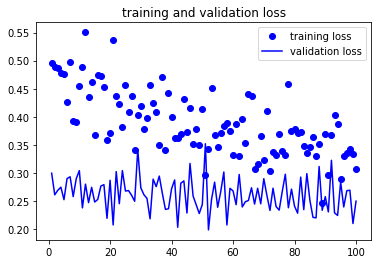

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

## Print out validation loss and accuracy

In [0]:
val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)

In [0]:
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

Validation loss: 0.30772452486878865
Validation accuracy: 0.9679999923706055


## Save the model

In [0]:
model.save(file_prefix + model_name + '_step2.h5' )

In [0]:
# from google.colab import files

# with open(model_fname, 'r') as f:
#   files.download(model_fname)

## Conclusions

I used more aggressive data augmentation and dropouts for fully connected network to get better results.

Also I used `preprocess_input` from `keras.applications.vgg19` in the ImageDataGenerator. It improved accuracy considerably.